In [31]:
import re
import os
import json

In [5]:
load_tests("./data/mold_test_imgs/")

TypeError: __init__() got an unexpected keyword argument 'id'

In [ ]:
import configparser

# Loads the config file passed in as a parameter
def load_config(config_file):
    config = configparser.ConfigParser()
    config.read(config_file)
    return config

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [28]:
cmaps = ['gray', 'blue']
chs = [1,2,3,4,5]
if len(cmaps) < len(chs):
    cmaps += [cmaps[-1]] * (len(chs) - len(cmaps))
cmaps

['gray', 'blue', 'blue', 'blue', 'blue']

In [120]:
from importlib import reload
import encasm.env
reload(encasm.env)
from encasm.env import PetriDish

In [121]:
test_env = PetriDish.from_config_file("test", "./encasm/configs/default_config.ini")

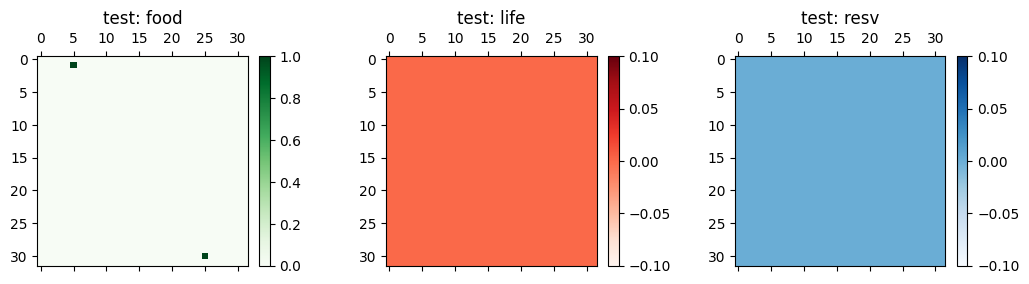

In [122]:
test_env.generate_food()

test_env.display()

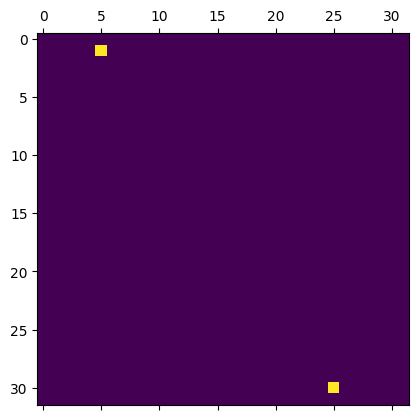

In [142]:
test_env.food = np.random.rand(32,32)
plt.matshow(test_env.channels[...,0])

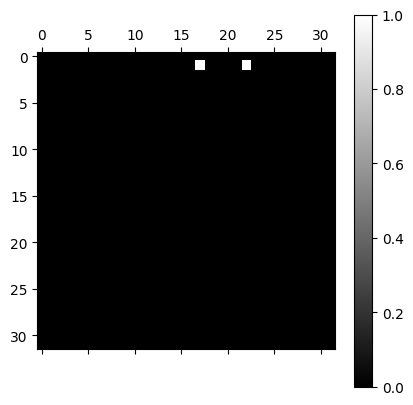

In [77]:
plt.matshow(test_env.food, cmap='gray')
plt.colorbar()

In [258]:
# test_envs["small"]['3']['1'].display()


In [259]:
a = np.arange(0, 100, 1).reshape(10,10)
b = a[1:-1, 1:-1]
a[:-2,1:-1] + a[1:-1, :-2] + a[1:-1, 2:] + a[2:, 1:-1]

array([[ 44,  48,  52,  56,  60,  64,  68,  72],
       [ 84,  88,  92,  96, 100, 104, 108, 112],
       [124, 128, 132, 136, 140, 144, 148, 152],
       [164, 168, 172, 176, 180, 184, 188, 192],
       [204, 208, 212, 216, 220, 224, 228, 232],
       [244, 248, 252, 256, 260, 264, 268, 272],
       [284, 288, 292, 296, 300, 304, 308, 312],
       [324, 328, 332, 336, 340, 344, 348, 352]])

In [338]:
import scipy.signal as signal

import utils.videowriter
reload(utils.videowriter)
from utils.videowriter import VideoWriter
import encasm
reload(encasm)
import encasm.eval
reload(encasm.eval)
from encasm.eval import load_tests

data_dir = "./encasm/example_networks/"
test_envs = load_tests(folder = data_dir)

import encasm.env
reload(encasm.env)
from encasm.env import PetriDish


In [361]:
# applies a 2d convolution to the grid using scipy and the given kernel
def convolve(grid, kernel):
    return signal.convolve2d(grid, kernel, mode='same', boundary='fill', fillvalue=0)

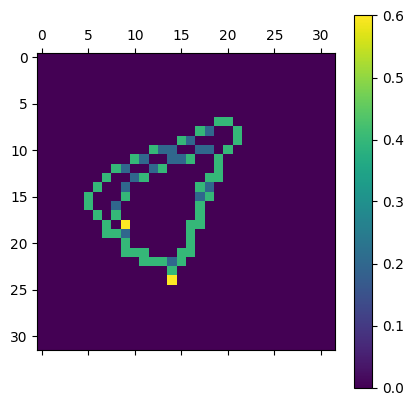

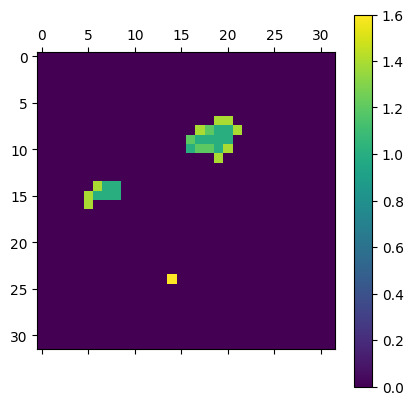

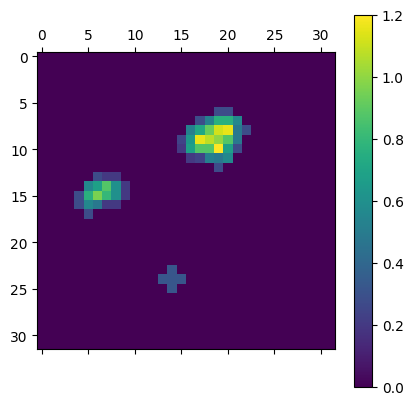

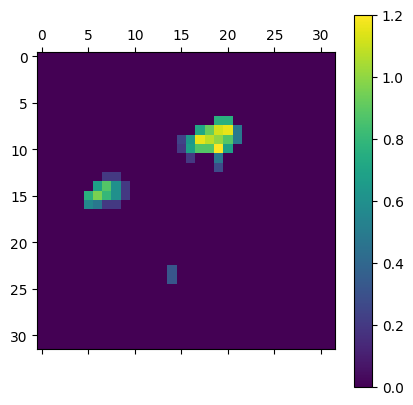

In [356]:
tenv = PetriDish.from_env("tenv", test_envs["small"]['3']['1'])
tenv.resv += tenv.food

kernel = np.array([[0,1,0],[1,0,1],[0,1,0]], dtype=np.float32)
# Represents the percentage of nutrients lost to diffusion outside of the road network
edge_reinforcer = convolve(tenv.life == 0, kernel) * tenv.life*0.2
kernel[1,1] = 1
kernel = kernel * 0.2
plt.matshow(edge_reinforcer)
plt.colorbar()
# shows result in between each step
tenv.resv += tenv.resv * edge_reinforcer # Nutrients that would leave the cell stays in
plt.matshow(tenv.resv)
plt.colorbar()

diffused = convolve(tenv.resv, kernel)
plt.matshow(diffused)
plt.colorbar()
tenv.resv = diffused*tenv.life
plt.matshow(tenv.resv)
plt.colorbar()

In [370]:
def diffuse(r,l):
    kernel = np.array([[0,1,0],[1,1,1],[0,1,0]], dtype=np.float32)
    nneighs = convolve(l, kernel) * l

    r[nneighs.nonzero()] = 5./nneighs[nneighs.nonzero()] * r[nneighs.nonzero()]

    kernel[1,1] = 1
    kernel = kernel * 0.2
    diffused = convolve(r, kernel) * l
    return diffused

In [389]:
tenv = PetriDish.from_env("tenv", test_envs["large"]['6']['2'])
tenv.resv += tenv.life

# Records a video of diffusion in tenv
with VideoWriter("./encasm/results/diffusion.mp4", fps=10) as vid:
    vid.add_concat_grids([tenv.resv], cols = 1)
    print(tenv.resv.sum())

    for i in range(200):
        # tenv.resv += tenv.resv * edge_reinforcer # Nutrients that would leave the cell stays in
        # diffused = convolve(tenv.resv, kernel)
        # tenv.resv = diffused*tenv.life
        tenv.resv = np.clip(tenv.resv + tenv.food*0.1, 0, 1)
        tenv.resv = diffuse(tenv.resv, tenv.life)
        # sets 10% of all life cells to 0
        tenv.resv[tenv.life.nonzero()] *= np.random.rand(*tenv.life[tenv.life.nonzero()].shape) > 0.001
        if i%10 == 0:
            vid.add_concat_grids([tenv.resv], cols = 1)
    print(tenv.resv.sum())

3658.0
2786.7683408407775


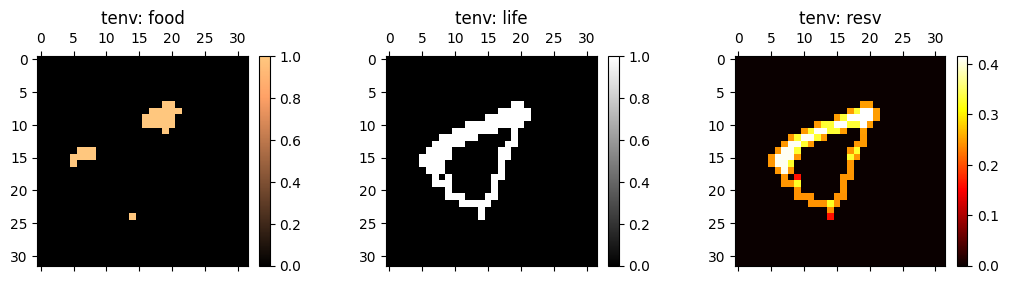

In [379]:
tenv.display()

27.0
27.000000000000007


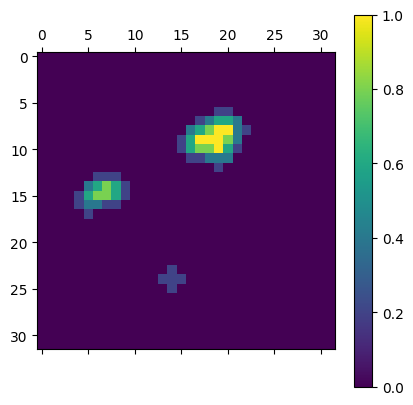

In [261]:

kernel = np.array([[0,0.2,0],[0.2,0.2,0.2],[0,0.2,0]])


tenv.resv += tenv.food
print(tenv.resv.sum())
grid = convolve(tenv.resv, kernel)
print(grid.sum())

plt.matshow(grid)
plt.colorbar()

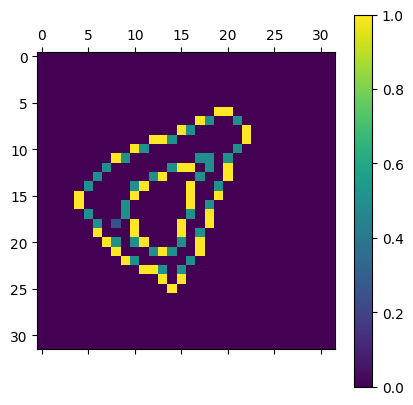

In [262]:
kernel = np.array([[0,1,0],[1,100,1],[0,1,0]])
edges = convolve(tenv.life, kernel)
edges[edges>100] = 0
edges[edges.nonzero()] = 1.0/edges[edges.nonzero()]
plt.matshow(edges)
plt.colorbar()

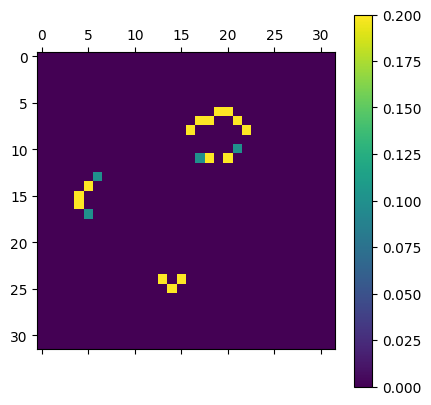

In [265]:
plt.matshow(edges*grid)
plt.colorbar()

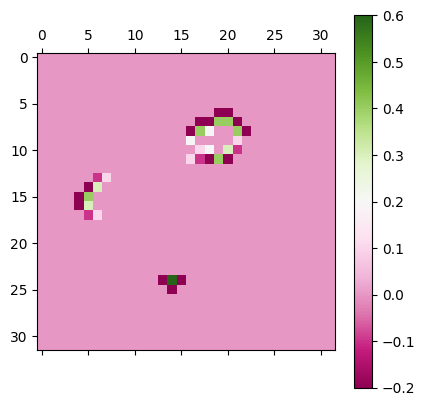

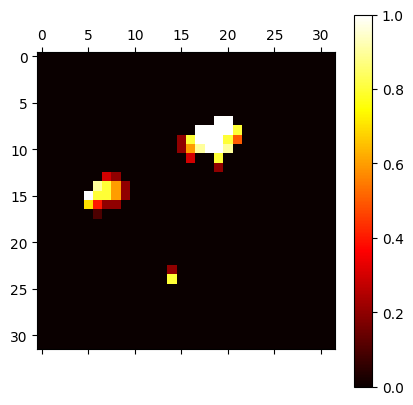

In [266]:
kernel = np.array([[0,0.2,0],[0.2,0.2,0.2],[0,0.2,0]])
plt.matshow(convolve(edges*grid*, kernel) * tenv.life + edges*grid*-1, cmap = "PiYG")
plt.colorbar()
newcombined = (grid + convolve(edges*grid*5, kernel)) * tenv.life
plt.matshow(newcombined, cmap='hot')
plt.colorbar()

In [313]:
tenv.life = np.ones_like(tenv.life)


In [314]:
# applies a 2d convolution to the grid using scipy and the given kernel
def convolve(grid, kernel):
    return signal.convolve2d(grid, kernel, mode='same', boundary='wrap')

def diffuse(grid, mask):
    kernel = np.array([[0,1,0],[1,100,1],[0,1,0]])
    edges = convolve(tenv.life, kernel)
    edges[edges>100] = 0
    edges[edges.nonzero()] = 1.0/edges[edges.nonzero()]

    kernel = np.array([[0,0.2,0],[0.2,0.2,0.2],[0,0.2,0]])
    diffused = convolve(tenv.resv, kernel)

    return (diffused + convolve(edges*diffused*5, kernel)) * mask

In [317]:
tenv.resv += tenv.food
with VideoWriter("./encasm/results/test.mp4", fps=30) as vid:
    for i in range(500):
        tenv.resv = np.clip(tenv.resv + tenv.food*1, 0, 100)
        tenv.resv = diffuse(tenv.resv, tenv.life)
        # sets 10 of resevoir cells to 0 randomly
        # tenv.resv[np.random.randint(0, tenv.resv.shape[0], 10), np.random.randint(0, tenv.resv.shape[1], 10)] = 0

        vid.add_concat_grids([tenv.food,tenv.life,tenv.resv])

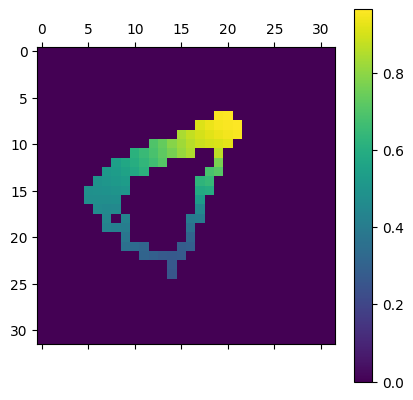

In [295]:
import io
from PIL import Image
plt.matshow(tenv.resv)
plt.colorbar()